# Khám phá dữ liệu, tiền xử lý

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
set_config(display='diagram') # Để trực quan hóa pipeline

### Đọc dữ liệu từ file

In [2]:
air_df = pd.read_csv('data.csv', sep = ',')

In [3]:
air_df.head()

,Unnamed: 0,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi
0,0,1121.52,2.49,15.59,6.62,7.03,51.11,60.88,6.21,5
1,1,767.71,1.48,12.00,32.90,8.46,36.26,42.39,3.52,4
2,2,727.65,1.41,10.11,51.50,8.35,35.83,41.03,3.23,4
3,3,727.65,1.03,8.82,77.25,8.94,39.41,44.50,3.58,4
4,4,761.03,0.59,7.37,103.00,9.18,46.39,51.56,3.99,4


#### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [4]:
air_df.shape

(13206, 10)

#### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Mỗi dòng trong DataFrame `air_df` cho biết dữ liệu về các chỉ số và chất lượng không khí của các tỉnh, thành phố từ 0h ngày 1/8/2021 - 0h ngày 1/9/2021 . Có vẻ không có vấn đề các dòng có ý nghĩa khác nhau.

#### Dữ liệu có các dòng bị lặp không?

In [5]:
air_df.index.duplicated().sum()

0

#### Mỗi cột có ý nghĩa gì?

<b>VARIABLE DESCRIPTIONS:</b>><br/>
<b>aqi </b>: <br/>  Chỉ số chất lượng không khí (1,2,3,4,5) với (1 = Good; 2 = Fair; 3 = Moderate; 4 = Poor ; 5 = Very Poor)<br/>
<b>co </b>:<br/>Nồng độ CO (Carbon monoxide), μg/m³<br/>
<b>no </b>:    
<br/>Nồng độ NO (Nitrogen monoxide), μg/m³<br/>
<b>no2 </b>:   
<br/> Nồng độ NO<sub>2</sub> (Nitrogen dioxide), μg/m³<br/>
<b>o3 </b>:    
<br/> Nồng độ O<sub>3</sub> (Ozone), μg/m³<br/>
<b>so2 </b>:   
<br/>Nồng độ SO<sub>2</sub> (Sulphur dioxide), μg/m³<br/>
<b>pm2_5 </b>: 
<br/> Nồng độ PM<sub>2_5</sub> (Fine particles matter), μg/m³<br/>
<b>pm10 </b>:  
<br/> Nồng độ PM<sub>10</sub> (Coarse particulate matter), μg/m³<br/>
<b>nh3 </b>:   
<br/> Nồng độ NH<sub>3</sub> (Ammonia), μg/m³<br/>

## Đưa ra câu hỏi cần trả lời

- Chất lượng không khí được tính như thế nào từ các chỉ số trong không khí đã được đo từ môi trường ?
<br/>
- Ý nghĩa thực tế của câu hỏi: Theo Tổ chức Y tế thế giới (WHO), hằng năm có 34.000 ca tử vong tại Việt Nam có liên quan đến ô nhiễm không khí. Việc xác định chất lượng không khí giúp người dân có các biện pháp bảo vệ bản thân và cộng đồng kịp thời như đeo khẩu trang, hạn chế sử dụng các phương tiện giao thông gây ô nhiễm, ... . Ngoài ra, chính quyền địa phương có thể hạn chế lượng khí thải từ các nhà máy, xí nghiệp, trồng thêm nhiều cây xanh để làm giảm ô nhiễm không khí.

# Khám phá dữ liệu(để biết tách các tập)

In [6]:
# Cột output hiện có kiểu dữ liệu gì?
air_df['aqi'].dtype

dtype('int64')

In [7]:
# Cột output có bao nhiêu giá trị thiếu?
air_df['aqi'].isna().sum()

0

In [8]:
# Tỉ lệ các lớp trong cột output?
air_df['aqi'].value_counts(normalize=True) * 100

1    31.909738
2    26.344086
4    22.088445
5    11.252461
3     8.405270
Name: aqi, dtype: float64

- Cột output đang ở kiểu dạng số, không có giá trị thiếu và tỉ lệ lớp 3 và 5 trong cột output chênh lệch nhiều so với các lớp còn lại, vì vậy hãy lấy random khoảng 40% lớp 1, 2, 4 để các lớp có tỉ lệ gần nhau nhất

In [9]:
aqi_124 = [1, 2, 4]
frames = []

for aqi in aqi_124:
    df = air_df.loc[air_df['aqi'] == aqi]
    frames.append(df.sample(frac = 0.4))
    
aqi_35 = [3, 5]
for aqi in aqi_35:
    df = air_df.loc[air_df['aqi'] == aqi]
    frames.append(df)
    
air_df_bal = pd.concat(frames)
air_df_bal

,Unnamed: 0,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi
8964,8964,260.35,0.00,1.48,6.88,0.24,1.87,2.47,0.70,1
10350,10350,387.19,0.04,1.35,60.08,0.76,9.54,9.84,0.48,1
7457,7457,290.39,0.00,5.23,24.32,2.09,6.84,9.52,1.71,1
130,130,440.60,0.18,7.37,28.61,4.47,6.40,7.69,3.74,1
10136,10136,290.39,0.00,1.19,35.76,0.37,2.21,2.40,0.30,1
...,...,...,...,...,...,...,...,...,...,...
13201,13201,2616.88,59.01,30.16,0.00,38.62,138.76,152.62,14.19,5
13202,13202,2590.18,64.37,29.47,0.00,41.96,144.76,158.74,14.31,5
13203,13203,2937.32,83.15,33.59,0.00,55.31,174.44,189.82,15.07,5
13204,13204,3471.37,109.97,42.50,0.00,73.43,219.32,237.25,14.69,5


- Kiểm tra lại 1 lần nữa tỉ lệ các giá trị ouput

In [10]:
air_df_bal['aqi'].value_counts(normalize=True) * 100

1    24.645520
5    21.721970
2    20.347902
4    17.058910
3    16.225698
Name: aqi, dtype: float64

## Tiền xử lý (tách các tập)

In [11]:
# Tách X và y
y_sr = air_df_bal["aqi"] # sr là viết tắt của series
X_df = air_df_bal.drop("aqi", axis=1)

In [12]:
# Tách tập huấn luyện,tập validation, tập test theo tỉ lệ 70%:20%:10%
temp_X_df, test_X_df, temp_y_sr, test_y_sr = \
                              train_test_split(X_df, y_sr, 
                                               test_size=0.1, 
                                               stratify=y_sr, 
                                               random_state=0)
train_X_df, val_X_df, train_y_sr, val_y_sr = \
                              train_test_split(temp_X_df, temp_y_sr, 
                                               test_size=2/9, 
                                               stratify=temp_y_sr, 
                                               random_state=0)


In [13]:
train_X_df.shape

(4788, 9)

In [14]:
train_y_sr.shape

(4788,)

In [15]:
val_X_df.shape

(1368, 9)

In [16]:
val_y_sr.shape

(1368,)

In [17]:
test_X_df.shape

(685, 9)

In [18]:
test_y_sr.shape

(685,)

In [19]:
train_X_df.head().index

Int64Index([3243, 6065, 5865, 10951, 360], dtype='int64')

# Khám phá dữ liệu (tập huấn luyện)

#### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [20]:
train_X_df.dtypes

Unnamed: 0      int64
co            float64
no            float64
no2           float64
o3            float64
so2           float64
pm2_5         float64
pm10          float64
nh3           float64
dtype: object

- Các cột đều có dữ liệu phù hợp

#### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [21]:
def missing_percentage(c):
    return (c.isna().mean() * 100).round(1)
def median(c):
    return c.quantile(0.5).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
train_X_df.agg([missing_percentage, 'min',lower_quartile, median,upper_quartile, 'max'])

,Unnamed: 0,co,no,no2,o3,so2,pm2_5,pm10,nh3
missing_percentage,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.0,166.89,0.00,0.20,0.00,0.04,0.50,0.54,0.00
lower_quartile,3259.5,377.20,0.00,2.90,8.00,1.10,10.20,12.00,0.90
median,6690.0,527.40,0.10,7.20,22.40,3.60,21.30,24.30,1.90
upper_quartile,10219.2,821.10,1.00,18.00,43.30,11.00,41.30,47.50,5.00
max,13205.0,14953.61,343.32,175.48,223.16,217.44,806.07,833.32,102.34


**Với mỗi cột input không có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?**

- Không có cột nào khác kiểu dữ liệu dạng số.

## Tiền xử lý (tập huấn luyện)

- Với các cột dạng số, ta sẽ điền giá trị thiếu bằng giá trị mean của cột <font color=gray>(gợi ý: dùng `SimpleImputer` trong Sklearn)</font>. Với *tất cả* các cột dạng số trong tập huấn luyện, ta đều cần tính mean, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới. 

- Cuối cùng, khi tất cả các cột đã được điền giá trị thiếu và đã có dạng số, ta sẽ tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn <font color=gray>(gợi ý: dùng `StandardScaler` trong Sklearn)</font>.

In [22]:
cols=list(train_X_df.columns)
temp=make_column_transformer(
        (SimpleImputer(strategy='mean'),cols))
preprocess_pipeline=make_pipeline(temp,StandardScaler())
preprocessed_train_X=preprocess_pipeline.fit_transform(train_X_df)

In [23]:
preprocess_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  ['Unnamed: 0', 'co', 'no',
                                                   'no2', 'o3', 'so2', 'pm2_5',
                                                   'pm10', 'nh3'])])),
                ('standardscaler', StandardScaler())])

## Tiền xử lý (tập validation)

In [24]:
preprocessed_val_X=preprocess_pipeline.transform(val_X_df)
preprocessed_val_X.shape

(1368, 9)

## Tiền xử lý + mô hình hóa

### Mô hình MLP- Classifier

- Ta sẽ sử dụng mô hình MLP để phân lớp (với các siêu tham số `hidden_layer_sizes=(20), activation='relu', solver='adam', random_state=0, max_iter=590`)
- Không chọn activation = tanh bởi vì làm tròn dữ liệu dưới dạng (0,1) nên việc sử dụng rất khó để hội tụ.
- Chọn solver = adam vì dữ liệu trên các tập dữ liệu tương đối lớn (13206 dòng)

In [25]:
neural_net_model = MLPClassifier(hidden_layer_sizes=(20,), activation='relu',\
                                 solver = 'adam', random_state = 0, max_iter = 590)

full_pipeline = make_pipeline(preprocess_pipeline, neural_net_model)

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.01, 0.1, 0.5, 1, 10]
best_val_err = float('inf')
best_alpha = None
for alpha in alphas:
    full_pipeline.set_params(mlpclassifier__alpha = alpha)

    full_pipeline.fit(train_X_df, train_y_sr)
    train_errs.append((1 - full_pipeline.score(train_X_df, train_y_sr)) * 100)
    val_errs.append((1 - full_pipeline.score(val_X_df, val_y_sr)) * 100)

best_val_err = min(val_errs)
index = val_errs.index(min(val_errs))
best_alpha = alphas[index]

'Finish!'

'Finish!'

In [26]:
full_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('simpleimputer',
                                                                   SimpleImputer(),
                                                                   ['Unnamed: '
                                                                    '0',
                                                                    'co', 'no',
                                                                    'no2', 'o3',
                                                                    'so2',
                                                                    'pm2_5',
                                                                    'pm10',
                                                                    'nh3'])])),
                                 ('standardscaler', StandardScaler())])),
                ('mlpclassifier',
                 MLPClassifier(alpha=10, hidden_layer_sizes=(20,), max_iter=590,
                               random_state=0))])

#### Độ lỗi trên tập train

Text(0, 0.5, 'alpha')

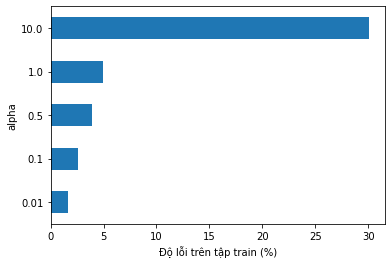

In [27]:
ax = pd.Series(train_errs, index = alphas).plot.barh()
ax.set_xlabel('Độ lỗi trên tập train (%)')
ax.set_ylabel('alpha')

#### Độ lỗi trên tập valid

Text(0, 0.5, 'alpha')

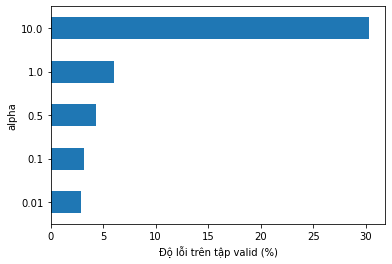

In [28]:
bx = pd.Series(val_errs, index = alphas).plot.barh()
bx.set_xlabel('Độ lỗi trên tập valid (%)')
bx.set_ylabel('alpha')

#### Độ lỗi nhỏ nhất trên tập valid và alpha tốt nhất

In [29]:
print('Best valid err: ', best_val_err.round(2), '%')
print()
print('Best alpha: ',best_alpha)

Best valid err:  2.85 %

Best alpha:  0.01


Cuối cùng, huấn luyện lại `full_pipeline` trên `X_df` và `y_sr` (tập huấn luyện + tập validation) với `best_alpha` tìm được ở trên để ra được mô hình cụ thể cuối cùng.

In [30]:
full_pipeline.set_params(mlpclassifier__alpha = best_alpha)

full_pipeline.fit(temp_X_df, temp_y_sr)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('simpleimputer',
                                                                   SimpleImputer(),
                                                                   ['Unnamed: '
                                                                    '0',
                                                                    'co', 'no',
                                                                    'no2', 'o3',
                                                                    'so2',
                                                                    'pm2_5',
                                                                    'pm10',
                                                                    'nh3'])])),
                                 ('standardscaler', StandardScaler())])),
                ('mlpclassifier',
                 MLPClassifier(alpha=0.01, hidden_layer_sizes=(20,),
                               max_iter=590, random_state=0))])

In [31]:
errors_temp=[]
errors_test=[]

### Đánh giá mô hình tìm được:
Đánh giá mô hình tìm được với test data

In [32]:
#Độ lỗi trên tập (train+validation)
err = ((1-full_pipeline.score(temp_X_df, temp_y_sr)) * 100).round(2)
errors_temp.append(err)
print('Error with train+val data: ', err, '%')

Error with train+val data:  1.74 %


In [33]:
#Độ lỗi trên tập test
err = ((1-full_pipeline.score(test_X_df, test_y_sr)) * 100).round(2)
errors_test.append(err)
print('Error with test data: ', err, '%')

Error with test data:  2.34 %


### Nhận xét
- Mô hình MLP-Classifier fit khá tốt trên tập dữ liệu<br/>
- Độ lỗi trên tập valid tỉ lệ thuận với alpha trên cả tập (train+val) và tập test<br/>

### Mô hình Softmax Regression

In [34]:
log_reg_model = LogisticRegression(multi_class = 'multinomial')
full_pipeline_2 = make_pipeline(preprocess_pipeline, log_reg_model)
full_pipeline_2.fit(temp_X_df, temp_y_sr)

C:\Users\3442\miniconda3\envs\min_ds-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('simpleimputer',
                                                                   SimpleImputer(),
                                                                   ['Unnamed: '
                                                                    '0',
                                                                    'co', 'no',
                                                                    'no2', 'o3',
                                                                    'so2',
                                                                    'pm2_5',
                                                                    'pm10',
                                                                    'nh3'])])),
                                 ('standardscaler', StandardScaler())])),
                ('logisticregression',
                 LogisticRegression(multi_class='multinomial'))])

In [35]:
#Độ lỗi trên tập (train+validation)
err = ((1-full_pipeline_2.score(temp_X_df, temp_y_sr)) * 100).round(2)
print('Error with train+valid data: ', err, '%')
errors_temp.append(err)

Error with train+valid data:  5.75 %


In [36]:
#Độ lỗi trên tập test
err = ((1-full_pipeline_2.score(test_X_df, test_y_sr)) * 100).round(2)
print('Error with test data: ', err, '%')
errors_test.append(err)

Error with test data:  5.99 %


### Nhận xét
- Độ lỗi trên cả hai không chênh lệch quá nhiều <br/>
- Mô hình fit khá ổn trên tập dữ liệu

### Mô hình K-Neighbors Classifier

Thử nghiệm nhiều giá trị của siêu tham số n_neighbors để tìm được độ lỗi trên tập validation tối ưu.

In [37]:
full_pipeline_3 = make_pipeline(preprocess_pipeline,KNeighborsClassifier())
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
n_neighbors = [2, 3, 4, 5, 6,10,20,30,40,50]
best_val_err = float('inf')
best_neighbor = None
for neighbor in n_neighbors:
    full_pipeline_3.set_params(kneighborsclassifier__n_neighbors = neighbor)
    full_pipeline_3.fit(train_X_df, train_y_sr)
    train_errs.append((1 - full_pipeline_3.score(train_X_df, train_y_sr)) * 100)
    val_errs.append((1 - full_pipeline_3.score(val_X_df, val_y_sr)) * 100)

best_val_err = min(val_errs)
index = val_errs.index(min(val_errs))
best_neighbor = n_neighbors[index]

'Finish!'

'Finish!'

#### Độ lỗi trên tập train

Text(0, 0.5, 'neighbor')

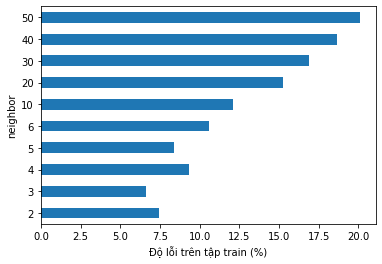

In [38]:
cx = pd.Series(train_errs, index = n_neighbors).plot.barh()
cx.set_xlabel('Độ lỗi trên tập train (%)')
cx.set_ylabel('neighbor')

#### Độ lỗi trên tập valid

Text(0, 0.5, 'neighbor')

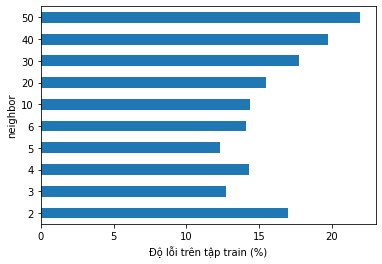

In [39]:
dx = pd.Series(val_errs, index = n_neighbors).plot.barh()
dx.set_xlabel('Độ lỗi trên tập train (%)')
dx.set_ylabel('neighbor')

#### Độ lỗi nhỏ nhất trên tập valid và neighbor tốt nhất

In [40]:
print('Best valid err: ', best_val_err.round(2), '%')
print()
print('Best neighbor: ',best_neighbor)

Best valid err:  12.28 %

Best neighbor:  5


Cuối cùng, huấn luyện lại `full_pipeline` trên `X_df` và `y_sr` (tập huấn luyện + tập validation) với `best_neighbor` tìm được ở trên để ra được mô hình cụ thể cuối cùng.

In [41]:
full_pipeline_3.set_params(kneighborsclassifier__n_neighbors = best_neighbor)

full_pipeline_3.fit(temp_X_df, temp_y_sr)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('simpleimputer',
                                                                   SimpleImputer(),
                                                                   ['Unnamed: '
                                                                    '0',
                                                                    'co', 'no',
                                                                    'no2', 'o3',
                                                                    'so2',
                                                                    'pm2_5',
                                                                    'pm10',
                                                                    'nh3'])])),
                                 ('standardscaler', StandardScaler())])),
                ('kneighborsclassifier', KNeighborsClassifier())])

### Đánh giá mô hình tìm được:

In [42]:
#Độ lỗi trên tập (train+validation)
err = ((1-full_pipeline_3.score(temp_X_df, temp_y_sr)) * 100)
errors_temp.append(err)
print('Error with train+val data: ', err, '%')

Error with train+val data:  8.122157244964267 %


In [43]:
#Độ lỗi trên tập test
err = ((1-full_pipeline_3.score(test_X_df, test_y_sr)) * 100).round(2)
errors_test.append(err)
print('Error with test data: ', err, '%')

Error with test data:  12.99 %


### Nhận xét
- Độ lỗi trên tập test cao hơn trên tập (train+val)

## Mô hình tốt nhất


<function matplotlib.pyplot.show(close=None, block=None)>

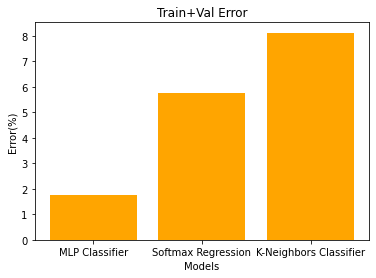

In [44]:
divisions=['MLP Classifier','Softmax Regression','K-Neighbors Classifier']
plt.bar(divisions,errors_temp,color='orange')
plt.title('Train+Val Error')
plt.xlabel('Models')
plt.ylabel('Error(%)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

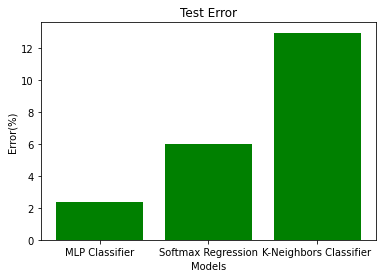

In [45]:
plt.bar(divisions,errors_test,color='green')
plt.title('Test Error')
plt.xlabel('Models')
plt.ylabel('Error(%)')
plt.show

- Dựa vào độ lỗi trên tập test trên ta thấy mô hình MLP Classifier hoạt động hiệu quả hơn hai mô hình còn lại => dự đoán chất lượng không khí tốt nhất.

## Nhìn lại quá trình làm đồ án

### Những khó khăn đã gặp phải

- Quang: lựa chọn mô hình phù hợp với dữ liệu đã dùng, tốn thời gian trong việc tìm kiếm nguồn cung dữ liệu (một số webiste yêu cầu trả phí hoặc gửi email xin xác nhận mục đích sử dụng để truy cập dữ liệu).
- Sơn: 

### Những kỹ năng đã học được

- Quang: qua đồ án này em có thêm kinh nghiệm để chọn lọc và thu thập dữ liệu, hiểu thêm nhiều thuật toán phân lớp hữu ích
- Sơn: 

### Nếu có thêm thời gian:
nhóm sẽ tìm và thu thập dữ liệu đa dạng, phức tạp hơn, có thể thử nghiệm thu thập dữ liệu bằng cách parse HTML và mô hình hóa dữ liệu với nhiều thuật toán khác.

## Tài liệu tham khảo

https://openweathermap.org/api/air-pollution<br/>
https://scikit-learn.org/ <br/>
https://stackoverflow.com/<br/>
Video bài giảng + demo của môn học+ slide bài giảng<br/>
Homework:1,2,3